In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
import numpy as np
from arnie.pfunc import pfunc
from arnie.free_energy import free_energy
from arnie.bpps import bpps
from arnie.mfe import mfe
import arnie.utils as utils
from decimal import Decimal

Populating the interactive namespace from numpy and matplotlib


## A starting example

Hammerhead ribozyme example sequence:

In [2]:
sequence = "CGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCG"

Calculate a minimum free energy structure:

In [3]:
mfe_structure = mfe(sequence)
print(mfe_structure)

((((((.((((((......)))))).......((((.....))))...))))))


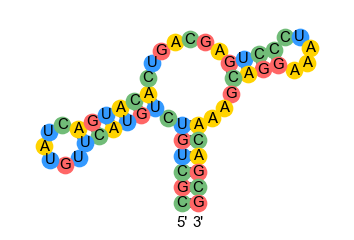

In [4]:
#Visualize with draw_rna! Git clone from www.github.com/DasLab/draw_rna .
from ipynb.draw import draw_struct

draw_struct(sequence, mfe_structure)

Calculate an array of base-pairing probabilities. If our sequence is length N, this produces an NxN matrix, where entry i, j corresponds to the probability that nucleotides _i_ and _j_ are paired.

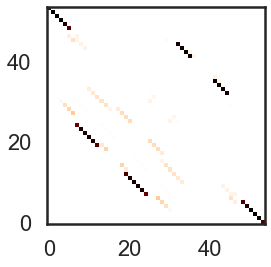

In [5]:
bp_matrix = bpps(sequence)
plt.imshow(bp_matrix, origin='lower left', cmap='gist_heat_r')

What if we want the total probability that any nucleotide is unpaired? This gives us a prediction of how accessible the nucleotide is, which is important in a lot of contexts -- a prediction for structure probing data, a prediction for degradation rate, and possibly a prediction for protein binding.

To get the total probability that nucleotide _i_ is *paired*, we sum the above base pair matrix along one axis (doesn't matter which since it's symmetric). This gives us a 1xN vector. Then to get the probability that nucleotide _i_ is *unpaired*, we subtract this vector from 1.

Text(0, 0.5, 'p(unpaired)')

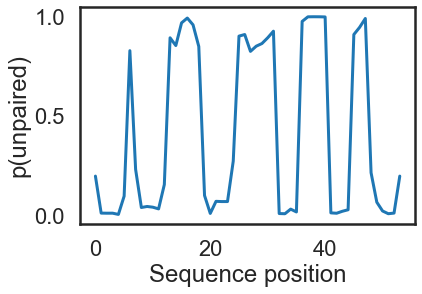

In [6]:
p_unp_vec = 1 - np.sum(bp_matrix, axis=0)
plot(p_unp_vec)
xlabel('Sequence position')
ylabel('p(unpaired)')

We can visualize the unpaired probabilities on our MFE structure, too:

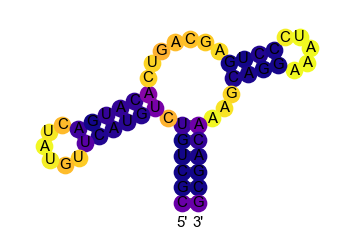

In [7]:
draw_struct(sequence, mfe_structure, c = p_unp_vec, cmap='plasma')
# yellow = higher unpaired probability, blue = higher paired probability

### More examples of syntax and functionality in arnie.

## Utilities

In [3]:
# see current path files:
utils.print_path_files()

rnastructure /Users/hwayment/das/software/RNAstructure/exe
linearpartition /Users/hwayment/das/software/LinearPartition/bin
linearfold /Users/hwayment/das/software/LinearFold/bin
rnasoft /Users/hwayment/das/software/MultiRNAFold
contrafold_2 /Users/hwayment/das/software/contrafold/src
vienna_2 /usr/local/bin
nupack /Users/hwayment/das/software/nupack3.0.6/bin
TMP /Users/hwayment/das/tmp
eternafold /Users/hwayment/das/github/Eternafold/src


Example output: (HWS, June 2021)

```
rnastructure /Users/hwayment/das/software/RNAstructure/exe
linearpartition /Users/hwayment/das/software/LinearPartition/bin
linearfold /Users/hwayment/das/software/LinearFold/bin
rnasoft /Users/hwayment/das/software/MultiRNAFold
contrafold_2 /Users/hwayment/das/software/contrafold/src
vienna_2 /usr/local/bin
nupack /Users/hwayment/das/software/nupack3.0.6/bin
TMP /Users/hwayment/das/tmp
eternafold /Users/hwayment/das/github/Eternafold/src
```

In [4]:
# get list of available working packages:
avail_packages = utils.package_list()
print('Available packages:', avail_packages)

Available packages: ['rnastructure', 'rnasoft', 'contrafold_2', 'vienna_2', 'nupack', 'eternafold']


Example output: (HWS, June 2021)

`Available packages: ['rnastructure', 'rnasoft', 'contrafold_2', 'vienna_2', 'nupack', 'eternafold']`

In [13]:
#agnostic to capitalization in package name.
#package version must be specified after package name by underscore, 'vienna_2', not 'vienna 2'.
for package_name in ['vienna','VIENNA','Vienna','vienna_2']:
    Z = free_energy(sequence,package=package_name)
    print(Z)

-15.92
-15.92
-15.92
-15.92


Expected output:
```

-15.92
-15.92
-15.92
-15.92
```

## Partition Function

In [5]:
# Compute Z: 

for pkg in avail_packages:
    Z = pfunc(sequence, package=pkg)
    print('%s %.2E' % (pkg, Z))

rnastructure 8.12E+12
rnasoft 2.88E+06
contrafold_2 9.67E+02
vienna_2 1.61E+11
nupack 2.92E+10
eternafold 9.36E+05


Expected output:

```
rnastructure 8.12E+12
rnasoft 2.88E+06
contrafold_2 9.67E+02
vienna_2 1.61E+11
nupack 2.92E+10
eternafold 9.36E+05
```

In [6]:
#To see the actual system calls, set DEBUG=True:

pfunc(sequence, DEBUG=True)

Reading Arnie file at /Users/hwayment/private_arnie/hws_macbook.arnie
/Users/hwayment/das/tmp/ujmhxt.in
/usr/local/bin/RNAfold -p -T 37 --bppmThreshold=0.0000000001 --id-prefix=svfvnp
stdout
b'>svfvnp_0001\nCGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCG\n((((((.((((((......)))))).......((((.....))))...)))))) (-15.20)\n((((((.((((((......)))))).......((((.....))))...)))))) [-15.92]\n((((((.((((((......)))))).......((((.....))))...)))))) {-15.20 d=2.79}\n frequency of mfe structure in ensemble 0.312934; ensemble diversity 4.96  \n'
stderr
b''
free_energy:  -15.92


161496367110.8372

Example output:

```
/Users/hwayment/das/tmp/rxphqu.in
/usr/local/bin/RNAfold -T 37 -p --id-prefix=tjwlzl
stdout
b'>tjwlzl_0001\nCGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCG\n((((((.((((((......)))))).......((((.....))))...)))))) (-15.20)\n((((((.((((((......)))))).......((((.....))))...)))))) [-15.92]\n((((((.((((((......)))))).......((((.....))))...)))))) {-15.20 d=2.79}\n frequency of mfe structure in ensemble 0.312934; ensemble diversity 4.96  \n'
stderr
b''
free_energy:  -15.92
```

In [12]:
# Compute constrained Z, example here is of HHR ribozyme closing stem.
# Note not all packages can do this -- RNASoft will throw an error.

constr = '((((((..........................................))))))'

# Compute Z: 
print('Package\tconstr_Z\tZ\tp(motif)')
for pkg in avail_packages:
    Z = pfunc(sequence, package=pkg)
    constr_Z = pfunc(sequence, package=pkg, constraint=constr)
    p_closing_stem = constr_Z / Z
    
    print('%s\t%.2E\t%.2E\t%.2f' % (pkg, constr_Z, Z, p_closing_stem))

Package	constr_Z	Z	p(motif)
rnastructure	1.22E+08	8.12E+12	0.00
ERROR: RNAsoft is unable to handle constraints for calculating                 partition functions, returning unconstrained Z.
rnasoft	2.88E+06	2.88E+06	1.00
contrafold_2	3.59E+02	9.31E+02	0.39
vienna_2	1.03E+11	1.61E+11	0.64
nupack	2.92E+10	2.92E+10	1.00
eternafold	5.06E+05	1.02E+06	0.50


In [24]:
from arnie.mfe import mfe
from arnie.free_energy import free_energy

seq = 'CGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCG'

# Arnie mfe utility calls LinearFold for structure. Arnie free_energy utility calls LinearPartition for free energy.

print('Vienna RNAfold:')
print(mfe(seq))
print(free_energy(seq))

print('\nLinearFold-V:')
print(mfe(seq, linear=True))
print(free_energy(seq, linear=True))

print('\nCONTRAfold (v2_02):')
print(mfe(seq, package='contrafold', viterbi=True)) # setting viterbi=True because CONTRAfold default is MEA structure, not MFE structure
print(free_energy(seq, package='contrafold'))

print('\nLinearFold-C:')
print(mfe(seq, linear=True, package='contrafold'))
print(free_energy(seq, linear=True, package='contrafold',beam_size=100000000))

Vienna RNAfold:
((((((.((((((......)))))).......((((.....))))...))))))
-15.92

LinearFold-V:
((((((.((((((......)))))).......((((.....))))...))))))
-15.92

CONTRAfold (v2_02):
((((((.((((((......)))))).......((((.....))))...))))))
-6.87394

LinearFold-C:
((((((.((((((......)))))).......((((.....))))...))))))
-6.77342


## Accessing package-specific options

In [14]:
print("Vienna with dangles: %.2f" % free_energy(sequence,package='vienna_2',dangles=True))
print("Vienna no dangles: %.2f" % free_energy(sequence,package='vienna_2',dangles=False))
print('')
print("RNAStructure with dangles: %.2f" % free_energy(sequence,package='rnastructure',coaxial=True))
print("RNAStructure no dangles: %.2f" % free_energy(sequence,package='rnastructure',coaxial=False))
print('')
print("Vienna 37 C (standard): %.2f" % free_energy(sequence,package='vienna_2'))
print("Vienna 70 C: %.2f" % free_energy(sequence,package='vienna_2',T=70))

Vienna with dangles: -15.92
Vienna no dangles: -13.37

RNAStructure with dangles: -17.51
RNAStructure no dangles: -16.54

Vienna 37 C (standard): -15.92
Vienna 70 C: -5.19


In [15]:
#Will throw an error if a package doesn't support the selected option
print("Vienna: %.2f" % free_energy(sequence,package='vienna_2',coaxial=True))
print("Vienna: %.2f" % free_energy(sequence,package='vienna_2',coaxial=False))

Vienna: -15.92
Vienna: -15.92


### Predict base pair probabilities for all packages

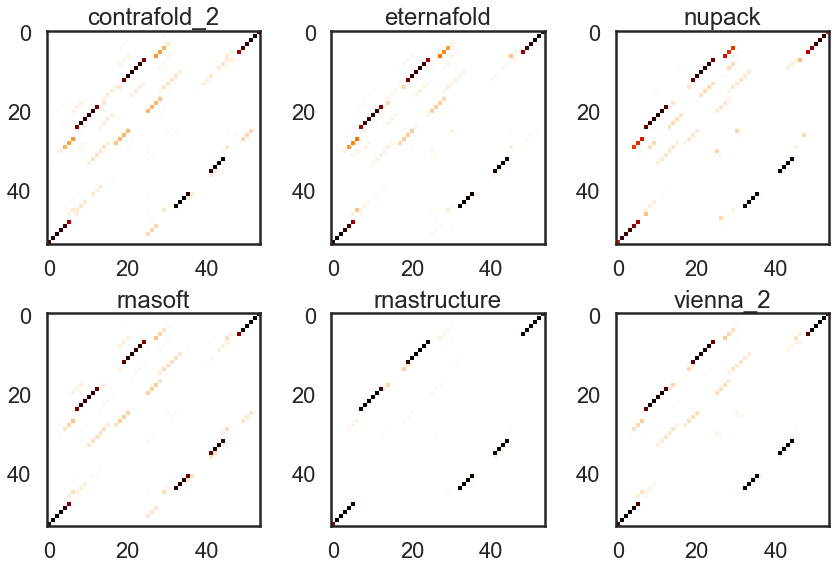

In [16]:
figure(figsize=(12,8))

for i,pkg in enumerate(sorted(avail_packages)):
    bp_matrix = bpps(sequence, package=pkg)
    subplot(2,3,i+1)
    axis(linewidth=0.5)
    imshow(bp_matrix,cmap='gist_heat_r')
    title(pkg)
    
tight_layout()
savefig('../assets/example_base_pair_matrices.png',dpi=150, bbox_inches='tight')

### Use base pair matrix to get p(unpaired) for all packages

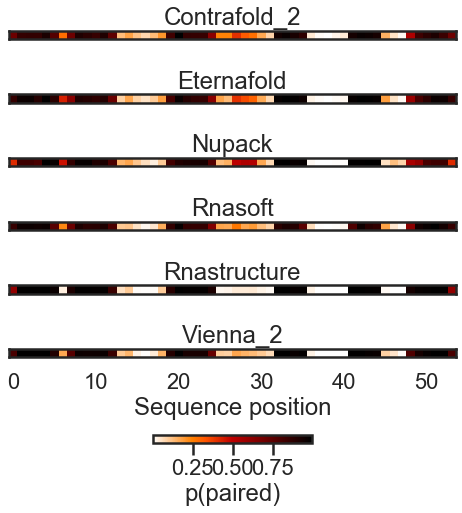

In [26]:
figure(figsize=(8,8))

for i,pkg in enumerate(sorted(avail_packages)):
    bp_matrix = bpps(sequence, package=pkg)
    
    # We sum all values over one axis to get total base pairing probability per nucleotide.
    
    p_net_base_pairing = np.sum(bp_matrix, axis=0)
    
    # to get total probability unpaired, we would take 1 - p_net_base_pairing.
    subplot(7,1,i+1)
    
    imshow(p_net_base_pairing.reshape(1,-1),cmap='gist_heat_r')
    yticks([])
    title(pkg.title())
    if i==5: 
        xlabel('Sequence position')
    else:
        xticks([])
        
subplot(7,1,7)
axis('off')
colorbar(orientation='horizontal', label='p(paired)')
savefig('../assets/example_avg_bp_per_nucleotide.png',dpi=150, bbox_inches='tight')


## Predict MEA structure from base pair probabilities

In [28]:
from arnie.mea.mea import MEA

ground_truth_struct = '((((((.((((((......)))))).......((((.....))))...))))))'

for pkg in avail_packages:
    
    bp_matrix = bpps(sequence, package=pkg)
    print('Scanning gamma for %s bp probabilities' % pkg)
    print("log_g\tstruct\tE[MCC]\tMCC")
    
    for log_gamma in range(-4,4):
        mea_mdl = MEA(bp_matrix,gamma=10**log_gamma)
        [exp_sen, exp_ppv, exp_mcc, exp_fscore] = mea_mdl.score_expected()
        [sen, ppv, mcc, fscore] = mea_mdl.score_ground_truth(ground_truth_struct)

        print("%d %s %.2f %.2f" % (log_gamma, mea_mdl.structure, exp_mcc, mcc))

Scanning gamma for rnastructure bp probabilities
log_g	struct	E[MCC]	MCC
-4 ...................................................... 0.00 0.00
-3 ...................................................... 0.00 0.00
-2 .((................................................)). 0.35 0.35
-1 .(((((.(((((........))))).......((((.....))))...))))). 0.93 0.93
0 ((((((.((((((......)))))).......((((.....))))...)))))) 0.96 1.00
1 ((((((.((((((......)))))).......((((.....))))...)))))) 0.96 1.00
2 (((((((((((((.(...)))))))..)....((((.....))))...)))))) 0.91 1.00
3 (((((((((((((.(...)))))))..).(..((((.....)))))..)))))) 0.89 1.00
Scanning gamma for rnasoft bp probabilities
log_g	struct	E[MCC]	MCC
-4 ...................................................... 0.00 0.00
-3 ...................................................... 0.00 0.00
-2 ...................................................... 0.00 0.00
-1 .((................................................)). 0.34 0.35
0 ((((((.((((((......)))))).......((((.....))))